<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_Coupled_Oscillator/blob/main/Lab3_Weakly_dumped_forced_oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3. Weakly dumped forced oscillator

Evgeny Kolonsky 2025

Code originated from [stackoverflow](https://stackoverflow.com/questions/67498084/animating-damped-oscillator)



In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D


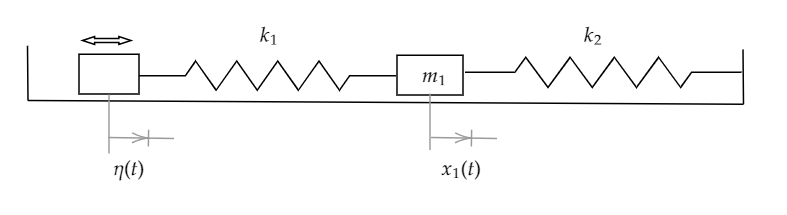

Motion equation

$$
\ddot x + \frac{1}{\tau} \dot x + \frac{k_1+k_2}{m} x = \eta_0 \frac{k_1}{k_1+k_2}\omega_0^2 \cos \omega t, \qquad \omega_0^2 = \frac{k_1+k_2}{m}
$$

Constants and parameters

In [102]:
# Constants
# elastic coefficients
k1 = 4.6 # N/m
k2 = 6.2 # N/m
k1_length = 20e-2 # m
k = k1 + k2 # total elastic coefficient
# oscillaator mass
m = 217e-3 # kg
# Quality
tau = 10 #s viscous friction parameter
# natural frequency
w0 = np.sqrt(k / m) # natural frequency
f0 = w0 / (2 * np.pi) # natural frequency in Hz

# external force
f = 1.2 # Hz
w = 2 * np.pi * f #angular frequency
eta0 = 5e-3 # external force amplitude

print(f'natural frequency:  {f0:.2f} Hz')
print(f'external frequency: {f:.2f} Hz')


natural frequency:  1.12 Hz
external frequency: 1.20 Hz


Initial conditions and animation parameters


In [97]:
# Initial conditions
x0 =  0. #Initial x position
vx0 = 0. #Initial x Velocity

# Setting time array for graph visualization
dt = 0.05 #s
Tmax = 2 * tau
N = int(Tmax / dt)
T = np.linspace(0, Tmax, N)
# skip some frames to speed up animation
frame_step = 2
interval = dt * 1000 * frame_step



numeric integration

In [104]:
#Function that implements rk4 integration
def rk4(t, x, f, dt):
    dx1 = f(t, x)*dt
    dx2 = f(t+0.5*dt, x+0.5*dx1)*dt
    dx3 = f(t+0.5*dt, x+0.5*dx2)*dt
    dx4 = f(t+dt, x+dx3)*dt
    return x+dx1/6.0+dx2/3.0+dx3/3.0+dx4/6.0

#Function that returns dX/dt for the linearly damped oscillator
def dXdt(t, X):
    x = X[0]
    vx = X[1]
    ax = - vx / tau - w0**2 * x + eta0 * w0**2 * k1/k * np.cos(w * t)
    return np.array([vx, ax])



t = np.linspace(0, Tmax, N, endpoint=False)
x = np.zeros(N)
vx = np.zeros(N)
# external force cart coordinate
xa = A0 * np.cos(w * t) - k1_length

# integrate equations of motion using rk4;
# X is a vector that contains the positions and velocities being integrated
X = np.array([x0, vx0])

for i in range(N):
    x[i] = X[0]
    vx[i] = X[1]
    # update the vector X to the next time step
    X = rk4(i*dt, X, dXdt, dt)


Animation

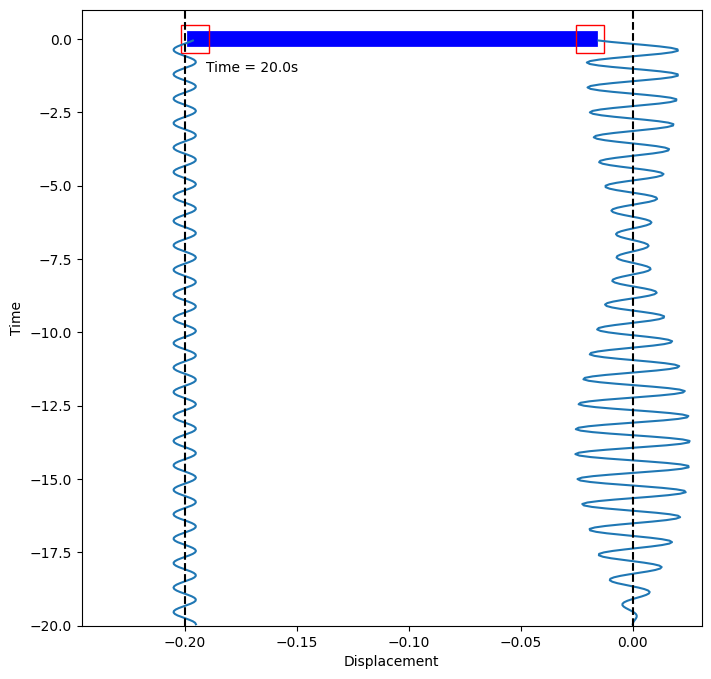

In [105]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

spring, = ax.plot([], [], lw=10,c="blue",ls="-",ms=20,marker="s",
                  mfc="r",fillstyle="none",mec="r",markevery=1)
#line2, = ax2.plot([], [], lw=1, color='r')
timeline_x = Line2D([], [])
timeline_xa = Line2D([], [])
ax.add_line(timeline_x)
ax.add_line(timeline_xa)
time_template = '\nTime = %.1fs'
time_text = ax.text(0.2, 0.9, '', transform=ax.transAxes)


ax.set_xlim(1.2*np.min(xa) ,  1.2 *np.max(np.abs(x) ))
ax.set_ylim(-Tmax, 1)
ax.set_xlabel('Displacement')
ax.set_ylabel('Time')
ax.axvline(x=-k1_length, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

def init():
    spring.set_data([], [])
    timeline_x.set_data([], [])
    timeline_xa.set_data([], [])
    time_text.set_text('')
    return spring, timeline_x, timeline_xa, time_text

def animate(i):
    spring.set_data([x[i],xa[i]], [0,0])
    elastic_extension = (x[i] - xa[i]) / k1_length
    spring.set_linewidth(10 / elastic_extension)
    timeline_x.set_data(x[:i], t[:i] - t[i])
    timeline_xa.set_data(xa[:i], t[:i] - t[i])

    time_text.set_text(time_template % (i*dt))
    return spring, timeline_x,  timeline_xa, time_text
ani = animation.FuncAnimation(fig, animate, np.arange(1, N, frame_step),
                              interval=interval, blit=True, init_func=init,repeat=False)

ani.save('anim.gif')

In [91]:
Tmax

4.0